In [1]:
# Translated to Python from https://github.com/matteonerini/ml-based-csi-feedback

import numpy as np
import pickle
from scipy.io import loadmat
from tqdm.notebook import tqdm

# Parameters
# na = 64               # Number of BS antennas
# nc = 160              # Number of OFDM subcarriers
# nTrain = 5000         # Number of training samples
# nTest = 2000          # Number of test samples
CR = 16               # Compression ratio
BTot = 256 * 5        # Total feedback bits
snrTrain = -1         # SNR for training in linear units
snrTest = -1          # SNR for testing in linear units
quantization = True   # Whether to quantize the compressed CSI
reduce_overhead = True # Whether to reduce overhead
our_data = True
C = 250


In [2]:
np.random.seed(42)

# Load data
if our_data:
    print('Importing our data')
    with open("../data/dataset1/batch1_1Lane_450U_1Rx_64Tx_1T_160K_2620000000.0fc.pickle", 'rb') as f: # change file link for your machine
        data = pickle.load(f)
    freq_channel = np.array(data["freq_channel"])
    freq_channel = np.squeeze(freq_channel)
    
    indices = np.random.permutation(freq_channel.shape[0])
    shuffled_data = freq_channel[indices]
    
    train_ratio = 0.8
    split_index = int(len(shuffled_data) * train_ratio)
    
    # Increase the length of the training data
    def duplicate_and_add_noise(data, times, noise_std_dev):
        duplicated_data = np.repeat(data, times, axis=0)  # Duplicate data k times
        noise = np.random.normal(0, noise_std_dev, duplicated_data.shape) + \
                1j * np.random.normal(0, noise_std_dev, duplicated_data.shape)
        return duplicated_data + noise
    
    duplicate_times = 5
    noise_std_dev = 1e-8
    H_train = shuffled_data[:split_index]
    H_train = duplicate_and_add_noise(H_train, duplicate_times, noise_std_dev)
    H_train = np.transpose(H_train, (1,2,0))
    
    H_test = shuffled_data[split_index:]
    H_test = duplicate_and_add_noise(H_test, duplicate_times, noise_std_dev)
    H_test = np.transpose(H_test, (1,2,0))
    
else:
    print('Importing Reference Data')
    H_train = loadmat('H_train.mat')['H_train']
    H_test = loadmat('H_test.mat')['H_test']

na = H_train.shape[0]
nc = H_train.shape[1]
nTrain = H_train.shape[2]
nTest = H_test.shape[2]

assert BTot < nTrain, "Larger BTot unsupported by func_allocate_bits"

Importing our data


In [3]:
print('Preprocessing Data')
# Uplink Training Data
HUL_train_n = H_train.copy()
Lambda = 1.0 / np.mean(np.abs(HUL_train_n)**2, axis=(0, 1))

if snrTrain != -1:
    nPower = 1.0 / (Lambda * snrTrain)
    HN = (np.random.randn(na, nc, nTrain) + 1j * np.random.randn(na, nc, nTrain)) * \
         np.sqrt(nPower[np.newaxis, np.newaxis, :] / 2)
    HUL_train_n += HN
    Lambda = 1.0 / np.mean(np.abs(HUL_train_n)**2, axis=(0, 1))

HUL_train_n *= np.sqrt(Lambda[np.newaxis, np.newaxis, :])
HUL_train_compl_tmp = HUL_train_n.reshape(na * nc, nTrain, order='F').T
HUL_train_compl_tmp_mean = np.mean(HUL_train_compl_tmp, axis=0)
HUL_train_compl = HUL_train_compl_tmp - HUL_train_compl_tmp_mean

Preprocessing Data


In [4]:
# Downlink Testing Data
HDL_test_n = H_test.copy()
Lambda = 1.0 / np.mean(np.abs(HDL_test_n)**2, axis=(0, 1))
HDL_test = HDL_test_n * np.sqrt(Lambda).reshape(1, 1, -1, order='F')
if snrTest != -1:
    for q in range(nTest):
        nPower = np.mean(np.abs(H_test[:, :, q])**2) / snrTest
        HDL_test_n[:, :, q] += (np.random.randn(na, nc) + 1j * np.random.randn(na, nc)) * \
                               np.sqrt(nPower / 2)
    Lambda = 1.0 / np.mean(np.abs(HDL_test_n)**2, axis=(0, 1))

HDL_test_n *= np.sqrt(Lambda[np.newaxis, np.newaxis, :])
HDL_test_compl_tmp = HDL_test_n.reshape(na * nc, nTest, order='F').T
HDL_test_compl = HDL_test_compl_tmp - HUL_train_compl_tmp_mean

print("Preprocessing complete.")


Preprocessing complete.


In [5]:
import matlab.engine
matlab = matlab.engine.start_matlab()

coeff_ori = np.array(matlab.pca(HUL_train_compl))

In [6]:
def func_rho(h_hat, h):
    """
    Calculate the correlation coefficient between the estimated channel (h_hat)
    and the actual channel (h).

    Parameters:
    h_hat (numpy.ndarray): Estimated channel matrix of shape (n, k).
    h (numpy.ndarray): Actual channel matrix of shape (n, k).

    Returns:
    float: Average correlation coefficient rho_h.
    """
    rho_i = 0
    n, k = h.shape

    for i in range(k):
        # Compute the correlation for each column
        numerator = abs(np.dot(h_hat[:, i].conj().T, h[:, i]))
        denominator = np.linalg.norm(h_hat[:, i]) * np.linalg.norm(h[:, i])
        rho_i += numerator / denominator

    # Average the correlation coefficients
    rho_h = rho_i / k
    return rho_h


def func_gram_schmidt(V):
    """
    Perform Gram-Schmidt orthogonalization on the columns of V.
    The input matrix V (n x k) is replaced by an orthonormal matrix U (n x k) 
    whose columns span the same subspace as V.

    Parameters:
    V (numpy.ndarray): Input matrix of shape (n, k).

    Returns:
    U (numpy.ndarray): Orthonormal matrix of shape (n, k).
    """
    n, k = V.shape
    U = np.zeros((n, k), dtype=V.dtype)

    # Normalize the first column
    U[:, 0] = V[:, 0] / np.linalg.norm(V[:, 0])

    # Iterate through remaining columns
    for i in range(1, k):
        U[:, i] = V[:, i]
        for j in range(i):
            projection = np.dot(U[:, j].conj().T, U[:, i]) / (np.linalg.norm(U[:, j])**2)
            U[:, i] -= projection * U[:, j]
        U[:, i] /= np.linalg.norm(U[:, i])

    return U


def func_nmse(h_hat, h):
    """
    Calculate the Normalized Mean Squared Error (NMSE) between the estimated
    channel (h_hat) and the actual channel (h).

    Parameters:
    h_hat (numpy.ndarray): Estimated channel matrix.
    h (numpy.ndarray): Actual channel matrix.

    Returns:
    float: NMSE value.
    """
    nmse_h = (np.linalg.norm(h_hat - h, 'fro') / np.linalg.norm(h, 'fro'))**2
    return nmse_h


def func_allocate_bits(BTot, importances, zUL_train_entries):
    """
    Allocate bits to minimize the theoretical distortion function.
    
    Parameters:
    BTot (int): Total number of feedback bits.
    importances (numpy.ndarray): Variance of principal components.
    zUL_train_entries (numpy.ndarray): Training entries, shape (nTrain, C, 2).

    Returns:
    numpy.ndarray: Array of bit allocations for principal components.
    """
    # Number of considered PCs
    NP = 1

    # Initialize bit allocations
    Bs = np.zeros(len(importances), dtype=int)
    Bs[0] = 1

    # Distortion function (df)
    df = np.copy(importances)
    kmeans = KMeans(n_clusters=2**Bs[0], n_init=10, random_state=0)
    z_entries_first_pc = zUL_train_entries[:, 0, :]  # First PC
    kmeans.fit(z_entries_first_pc)
    df[0] = np.sum(kmeans.inertia_) / zUL_train_entries.shape[0]
    df_new = np.copy(df)

    # Main allocation loop
    for bTot in range(2, BTot + 1):
        if bTot % 100 == 0:
            print(f"Considering bTot: {bTot}")

        for np_idx in range(1, NP + 2):  # np_idx starts from 1
            if np_idx == 1:  # For the first PC
                if df_new[np_idx - 1] == df[np_idx - 1]:
                    try:
                        z_entries_pc = zUL_train_entries[:, np_idx - 1, :]
                        kmeans = KMeans(n_clusters=2**(Bs[np_idx - 1] + 1), n_init=10, random_state=0)
                        kmeans.fit(z_entries_pc)
                        df_new[np_idx - 1] = np.sum(kmeans.inertia_) / zUL_train_entries.shape[0]
                    except Exception as e:
                        print(f"Error in k-means for PC {np_idx}: {e}")
            elif Bs[np_idx - 1] < Bs[np_idx - 2]:  # For other PCs
                if df_new[np_idx - 1] == df[np_idx - 1]:
                    try:
                        z_entries_pc = zUL_train_entries[:, np_idx - 1, :]
                        kmeans = KMeans(n_clusters=2**(Bs[np_idx - 1] + 1), n_init=10, random_state=0)
                        kmeans.fit(z_entries_pc)
                        df_new[np_idx - 1] = np.sum(kmeans.inertia_) / zUL_train_entries.shape[0]
                    except Exception as e:
                        print(f"Error in k-means for PC {np_idx}: {e}")

        # Improvement in distortion
        improvement = df - df_new
        assert np.min(improvement) >= 0, "Improvement should not be negative."

        # Find the PC with maximum improvement
        iMax = np.argmax(improvement)
        Bs[iMax] += 1
        NP = max(NP, iMax + 1)
        df[iMax] = df_new[iMax]

    # Return only non-zero bit allocations
    return Bs[:np.nonzero(Bs)[0][-1] + 1]


In [7]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.fftpack import fftn, ifftn

# Reduce Offloading Overhead
if reduce_overhead:
    print("Reducing offloading overhead...")
    coeff = np.zeros_like(coeff_ori)
    for i in range(coeff_ori.shape[1]):
        # Reshape the i-th principal component
        pc = coeff_ori[:, i].reshape((int(np.sqrt(na)), int(np.sqrt(na)), nc))

        # Perform FFT
        pcDFT = fftn(pc).flatten()

        # Create mask for top coefficients
        mask = np.zeros_like(pcDFT)
        locs = np.argsort(-np.abs(pcDFT))[:int(na * nc / CR)]  # Find top |na*nc/CR| values
        mask[locs] = 1

        # Apply the mask
        pcDFT = pcDFT * mask

        # Perform inverse FFT
        pcIFFT = ifftn(pcDFT.reshape((int(np.sqrt(na)), int(np.sqrt(na)), nc)))
        coeff[:, i] = pcIFFT.flatten()

    # Orthogonalize using Gram-Schmidt
    coeff = np.array(matlab.func_gram_schmidt(coeff[:, :500]))  # TODO Py gram_schmidt not working, matlab.func_gram_schmidt is working
else:
    coeff = coeff_ori

Reducing offloading overhead...


In [8]:
# Learn Quantization (k-means clustering training)

matlab.rng(69)
matlab.warning('off', 'stats:kmeans:FailedToConverge')

if quantization:
    print("Training k-means clustering...")

    # Project data using PCA
    zUL_train = np.dot(HUL_train_compl, coeff)
    zUL_train_entries = np.stack((np.real(zUL_train), np.imag(zUL_train)), axis=-1)

    # Calculate importances (variance of each PCA component)
    importances = np.var(zUL_train, axis=0)

    # Allocate bits for quantization
    Bs = np.squeeze(np.array(
        matlab.func_allocate_bits(BTot, importances, zUL_train_entries),
        dtype=np.int16
    ))
    C = len(Bs)

    # Scale data for k-means clustering
    zUL_train_entries_scaled = np.zeros((nTrain, C, 2))
    for i in range(C):
        zUL_train_entries_scaled[:, i, :] = zUL_train_entries[:, i, :] / np.sqrt(importances[i])

    # Determine the number of samples for k-means
    nTrainKMeans = min(nTrain, round(1e5 / C))
    zUL_train_entriesCSCG = zUL_train_entries_scaled[:nTrainKMeans, :C, :].reshape(-1, 2, order='F')

    # Train k-means for different bit levels
    quantLevelsCSCG = [None] * Bs[0]
    for i in tqdm(range(1, Bs[0] + 1)):
        quantLevelsCSCG[i-1] = np.array(
            matlab.kmeans(zUL_train_entriesCSCG,2**i, nargout=2)[1]   # Get cluster centers
        )
        # kmeans = KMeans(n_clusters=2**i, n_init=10)
        # kmeans.fit(zUL_train_entriesCSCG)
        # quantLevelsCSCG[i - 1] = kmeans.cluster_centers_

    # Scale quantization levels back
    quantLevels = [None] * C
    for i in range(C):
        quantLevels[i] = quantLevelsCSCG[Bs[i] - 1] * np.sqrt(importances[i])


Training k-means clustering...
Considering bTot: 100
Considering bTot: 200
Considering bTot: 300
Considering bTot: 400
Considering bTot: 500
Considering bTot: 600
Considering bTot: 700
Considering bTot: 800
Considering bTot: 900
Considering bTot: 1000
Considering bTot: 1100
Considering bTot: 1200


  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Testing
print("Testing...")

coeff_trunc = coeff[:, :C]
zDL = np.dot(HDL_test_compl, coeff_trunc)

if quantization:
    for i in range(zDL.shape[0]):
        for j in range(zDL.shape[1]):
            # Find the closest quantization level
            distances = np.abs(zDL[i, j] - (quantLevels[j][:, 0] + 1j * quantLevels[j][:, 1]))
            vecIdx = np.argmin(distances)
            zDL[i, j] = quantLevels[j][vecIdx, 0] + 1j * quantLevels[j][vecIdx, 1]

# Reconstruct the downlink channel
HDL_reconst_tmp = np.matmul(zDL, coeff_trunc.conj().T)
HDL_reconst = HDL_reconst_tmp + HUL_train_compl_tmp_mean
HDL_ori_reconst = HDL_reconst.T.reshape(na, nc, nTest, order='F')

Testing...


Assessing performance...
Plotting results...


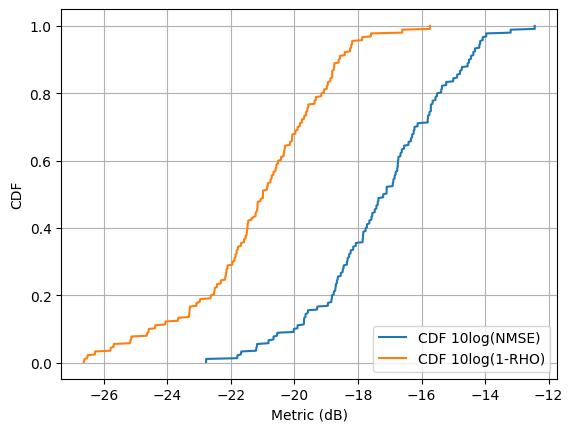

In [10]:
# Assessing performance
print("Assessing performance...")

nmse = np.zeros(nTest)
rho = np.zeros(nTest)

for i in range(nTest):
    ch = HDL_test[:, :, i]
    ch_h = HDL_ori_reconst[:, :, i]
    nmse[i] = func_nmse(ch_h, ch)  # Assumes func_nmse is defined
    rho[i] = func_rho(ch_h, ch)    # Assumes func_rho is defined

# Plotting results
print("Plotting results...")
LineW = 1.5

plt.figure()
cdf_nmse = np.sort(10 * np.log10(nmse))
cdf_rho = np.sort(10 * np.log10(1 - rho))

probabilities = np.arange(1, len(cdf_nmse) + 1) / len(cdf_nmse)

plt.plot(cdf_nmse, probabilities, label='CDF 10log(NMSE)', linewidth=LineW)
plt.plot(cdf_rho, probabilities, label='CDF 10log(1-RHO)', linewidth=LineW)

# plt.xlim([-22, 0])
# plt.xticks(range(-22, 1, 2))
plt.xlabel('Metric (dB)')
plt.ylabel('CDF')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving results
np.save(f'nmse-BTot{BTot}-CR{CR}.npy', nmse)
np.save(f'rho-BTot{BTot}-CR{CR}.npy', rho)


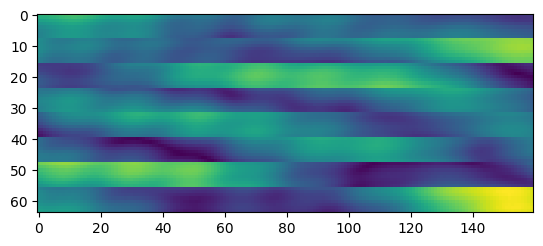

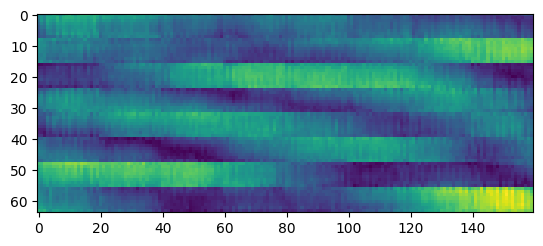

In [11]:
t = HDL_test[:,:,0]
t2 = HDL_ori_reconst[:,:,0]

plt.imshow(np.abs(t))
plt.show()
plt.imshow(np.abs(t2))
plt.show()
